# RNN Cell을 이용한 LSTM Model 제작

In [53]:
import warnings
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf

import math
import FinanceDataReader as fdr

warnings.filterwarnings('ignore')

In [54]:
tf.reset_default_graph() 

In [55]:
# 표준화
def data_standardization(x):
    x_np = np.asarray(x)
    return (x_np - x_np.mean()) / x_np.std()
 
# 너무 작거나 너무 큰 값이 학습을 방해하는 것을 방지하고자 정규화한다
# x가 양수라는 가정하에 최소값과 최대값을 이용하여 0~1사이의 값으로 변환
# Min-Max scaling
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7) # 1e-7은 0으로 나누는 오류 예방차원
 
# 정규화된 값을 원래의 값으로 되돌린다
# 정규화하기 이전의 org_x값과 되돌리고 싶은 x를 입력하면 역정규화된 값을 리턴한다
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [56]:
input_data_column_cnt = 5  # 입력데이터의 컬럼 개수(Variable 개수)
output_data_column_cnt = 2 # 결과데이터의 컬럼 개수

seq_length = 30       # 1개 시퀀스의 길이
rnn_cell_hidden_dim = 20   # 각 셀의 (hidden)출력 크기
forget_bias = 1.0          # 망각편향
num_stacked_layers = 2     # stacked LSTM layers 개수
keep_prob = 1.0            # dropout할 때 keep할 비율

epoch_num = 1000           # 에폭 횟수(학습에서 훈련 데이터를 모두 소진했을 때의 횟수)
learning_rate = 0.01       # 학습률 

In [57]:
data = fdr.DataReader('005930','2002-01-01','')

data

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2002-01-02,5660,6160,5620,6160,1142079,0.103943
2002-01-03,6100,6190,6020,6040,885636,-0.019481
2002-01-04,6380,6410,6290,6380,1009482,0.056291
2002-01-07,6260,6430,6170,6360,1029132,-0.003135
2002-01-08,6390,6390,6190,6230,760142,-0.020440
...,...,...,...,...,...,...
2022-11-24,61200,61700,60900,61400,8125010,0.006557
2022-11-25,61400,61700,60800,61000,6677933,-0.006515
2022-11-28,60500,60500,59800,60100,8589032,-0.014754


In [58]:
stock_info = data.values[:].astype(np.float) # 금액&거래량 문자열을 부동소수점형으로 변환한다

# 정규화
## 사용할 데이터
 가격
 거래량


In [59]:
price = stock_info[:,:-2] # 시작가, 최고가, 최저가, 종료가
price.shape
len(stock_info)
for i in range(len(stock_info)):
    if price[i][1]==0:
        price[i][1]=price[i][3]

for i in range(len(stock_info)):
    if price[i][2]==0:
        price[i][2]=price[i][3]


In [60]:
norm_price = min_max_scaling(price) # 가격형태 데이터 정규화 처리

In [61]:
# 거래량형태 데이터를 정규화한다
# ['Open','High','Low','Close','Adj Close','Volume']에서 마지막 'Volume'만 취함
# [:,-1]이 아닌 [:,-1:]이므로 주의하자! 스칼라가아닌 벡터값 산출해야만 쉽게 병합 가능
volume = stock_info[:,-2:-1]
norm_volume = min_max_scaling(volume) # 거래량형태 데이터 정규화 처리
print("volume.shape: ", volume.shape)
print("volume[0]: ", volume[0])
print("norm_volume[0]: ", norm_volume[0])
print("="*100) # 화면상 구분용

volume.shape:  (5170, 1)
volume[0]:  [1142079.]
norm_volume[0]:  [0.01264674]


In [62]:
# 행은 그대로 두고 열을 우측에 붙여 합친다
x = np.concatenate((norm_price, norm_volume), axis=1) # axis=1, 세로로 합친다
print("x.shape: ", x.shape)
print("x[0]: ", x[0])    # x의 첫 값
print("x[-1]: ", x[-1])  # x의 마지막 값
print("="*100) 

x.shape:  (5170, 5)
x[0]:  [0.05847107 0.06363636 0.05805785 0.06363636 0.01264674]
x[-1]:  [0.62396694 0.64256198 0.62190083 0.64256198 0.18188405]


In [63]:
y = x[:, [-2]] # 타켓은 주식 종가이다
print("y[0]: ",y[0])     # y의 첫 값
print("y[-1]: ",y[-1])   # y의 마지막 값

y[0]:  [0.06363636]
y[-1]:  [0.64256198]


In [64]:
dataX = [] # 입력으로 사용될 Sequence Data
dataY = [] # 출력(타켓)으로 사용

for i in range(0, len(y) - seq_length):
    _x = x[i : i+seq_length]
    _y = y[i + seq_length] # 다음 나타날 주가(정답)
    dataX.append(_x) # dataX 리스트에 추가
    dataY.append(_y) # dataY 리스트에 추가

In [65]:
# 학습용/테스트용 데이터 생성
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size


# 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])

# 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])

print('All data size: ',len(dataY))
print('Training data size: ',train_size)
print('Testing data size: ',test_size)


All data size:  5140
Training data size:  3597
Testing data size:  1543


In [66]:
# 텐서플로우 플레이스홀더 생성
# 입력 X, 출력 Y를 생성한다

X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt])
print("X: ", X)
Y = tf.placeholder(tf.float32, [None, 2])
print("Y: ", Y)

# 검증용 측정지표를 산출하기 위한 targets, predictions를 생성한다
targets = tf.placeholder(tf.float32, [None, 2])
print("targets: ", targets)

predictions = tf.placeholder(tf.float32, [None, 2])
print("predictions: ", predictions)

X:  Tensor("Placeholder:0", shape=(?, 30, 5), dtype=float32)
Y:  Tensor("Placeholder_1:0", shape=(?, 2), dtype=float32)
targets:  Tensor("Placeholder_2:0", shape=(?, 2), dtype=float32)
predictions:  Tensor("Placeholder_3:0", shape=(?, 2), dtype=float32)


In [67]:
# 모델(LSTM 네트워크) 생성
def lstm_cell():
    # LSTM셀을 생성
    # num_units: 각 Cell 출력 크기
    # forget_bias:  to the biases of the forget gate 
    #              (default: 1)  in order to reduce the scale of forgetting in the beginning of the training.
    # state_is_tuple: True ==> accepted and returned states are 2-tuples of the c_state and m_state.
    # state_is_tuple: False ==> they are concatenated along the column axis.
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim, 
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.tanh)
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

# num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()

# RNN Cell(여기서는 LSTM셀임)들을 연결
hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis: ", hypothesis)

# [:, -1]를 잘 살펴보자. LSTM RNN의 마지막 (hidden)출력만을 사용했다.
# 과거 여러 거래일의 주가를 이용해서 다음날의 주가 1개를 예측하기때문에 MANY-TO-ONE형태이다
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -2], output_data_column_cnt, activation_fn=tf.identity)

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
hypothesis:  Tensor("rnn/transpose_1:0", shape=(?, 30, 20), dtype=float32)


In [68]:
# 손실함수로 평균제곱오차를 사용한다
loss = tf.reduce_sum(tf.square(hypothesis - Y))
# 최적화함수로 AdamOptimizer를 사용한다
optimizer = tf.train.AdamOptimizer(learning_rate)
# optimizer = tf.train.RMSPropOptimizer(learning_rate) # LSTM과 궁합 별로임

train = optimizer.minimize(loss)

# RMSE(Root Mean Square Error)
# 제곱오차의 평균을 구하고 다시 제곱근을 구하면 평균 오차가 나온다
# rmse = tf.sqrt(tf.reduce_mean(tf.square(targets-predictions))) # 아래 코드와 같다
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

In [69]:
train_error_summary = [] # 학습용 데이터의 오류를 중간 중간 기록한다
test_error_summary = []  # 테스트용 데이터의 오류를 중간 중간 기록한다
test_predict = ''        # 테스트용데이터로 예측한 결과

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# 학습한다
start_time = datetime.datetime.now() # 시작시간을 기록한다
print('학습을 시작합니다...')
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch+1) % 100 == 0) or (epoch == epoch_num-1): # 100번째마다 또는 마지막 epoch인 경우
        # 학습용데이터로 rmse오차를 구한다
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error)

        # 테스트용데이터로 rmse오차를 구한다
        test_predict = sess.run(hypothesis, feed_dict={X: testX})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)

        # 현재 오류를 출력한다
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))

end_time = datetime.datetime.now() # 종료시간을 기록한다
elapsed_time = end_time - start_time # 경과시간을 구한다
print('elapsed_time:',elapsed_time)
print('elapsed_time per epoch:',elapsed_time/epoch_num)

학습을 시작합니다...


ValueError: Cannot feed value of shape (3597, 1) for Tensor 'Placeholder_1:0', which has shape '(?, 2)'

input_data_column_cnt: 5
output_data_column_cnt: 1
seq_length: 30
rnn_cell_hidden_dim: 20
forget_bias: 1.0
num_stacked_layers: 1
keep_prob: 1.0
epoch_num: 1000
learning_rate: 0.01
train_error: 0.026868805
test_error: 0.035994627
min_test_error: 0.030702135


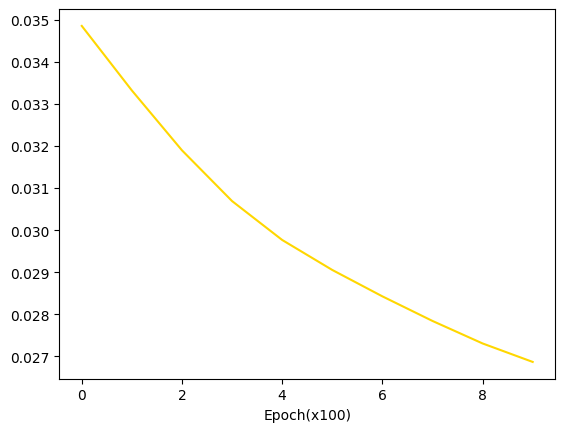

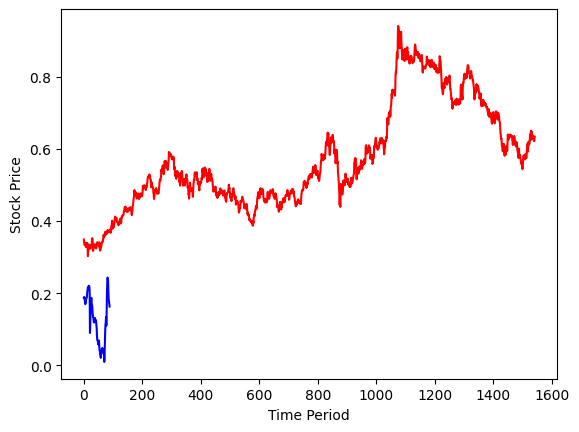

Text(0, 0.5, 'Root Mean Square Error')

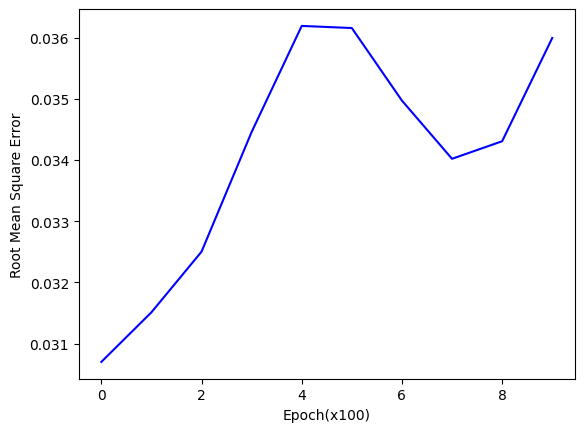

In [ ]:
# 하이퍼파라미터 출력
print('input_data_column_cnt:', input_data_column_cnt, end='')
print('\noutput_data_column_cnt:', output_data_column_cnt, end='')

print('\nseq_length:', seq_length, end='')
print('\nrnn_cell_hidden_dim:', rnn_cell_hidden_dim, end='')
print('\nforget_bias:', forget_bias, end='')
print('\nnum_stacked_layers:', num_stacked_layers, end='')
print('\nkeep_prob:', keep_prob, end='')

print('\nepoch_num:', epoch_num, end='')
print('\nlearning_rate:', learning_rate, end='')

print('\ntrain_error:', train_error_summary[-1], end='')
print('\ntest_error:', test_error_summary[-1], end='')
print('\nmin_test_error:', np.min(test_error_summary))

# 결과 그래프 출력
plt.figure(1)
plt.plot(train_error_summary, 'gold')
plt.xlabel('Epoch(x100)')

plt.figure(2)
plt.plot(testY, 'r')
plt.plot(test_predict, 'b')
plt.xlabel('Time Period')
plt.ylabel('Stock Price')
plt.show()

plt.figure(3)
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x100)')
plt.ylabel('Root Mean Square Error')

In [ ]:
import numpy as np

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

def MAPE(true, pred):
    return np.mean(np.abs((true-pred)/true))

def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred)))

def MSE(true, pred):
    return np.mean(np.square(true-pred))



In [ ]:
RMSE_value= "{:.2f}".format(np.sqrt(MSE(testY, test_predict[0][:])))
print("RMSE = ",RMSE_value)

MAE_value= "{:.2f}".format(MAE(testY, test_predict[0][:]))
print("MAE = ",MAE_value)

MAPE_value= "{:.2f}".format(MAPE(testY, test_predict[0][:]))
print("MAPE = ",MAPE_value)

SMAPE_value= "{:.2f}".format(SMAPE(testY, test_predict[0][:]))
print("SMAPE = ",SMAPE_value)

RMSE =  0.29
MAE =  0.27
MAPE =  0.84
SMAPE =  0.27


In [ ]:
# sequence length만큼의 가장 최근 데이터를 슬라이싱한다
recent_data = np.array([x[len(x)-seq_length : ]])
print("recent_data.shape:", recent_data.shape)

# 내일 종가를 예측해본다
test_predict = sess.run(hypothesis, feed_dict={X: recent_data})

print("test_predict", test_predict[0])
test_predict = reverse_min_max_scaling(price,test_predict) # 금액데이터 역정규화한다
print("Tomorrow's stock price", test_predict[0]) # 예측한 주가를 출력한다

recent_data.shape: (1, 30, 5)
test_predict [0.33919403]
Tomorrow's stock price [60786.074]


In [ ]:
test_predict[0][:]

array([60786.074], dtype=float32)